<a href="https://colab.research.google.com/github/lorenzopalaia/Progetto-Lab-IA/blob/main/GC_imgaug_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification (Image Augumentation)

In questa implementazione proviamo a sfruttare la tecnica di Image Augumentation, un processo di creazione di nuove immagini a partire da quelle esistenti in modo da allenare un modello con più dati. Andiamo allora ad applicare delle piccole modifiche alle immagini come, ad esempio, rendere una nuova immagine un po' più luminosa. Oppure potremmo ritagliare una parte dell'immagine originale, o ancora rifletterla su uno dei due assi. In generale l'intento rimane quello di ampliare il proprio dataset in modo da irrobustire il modello in fase di addestramento.

In questo caso andremo a lavorare con il contenuto della cartella `images_original` del dataset, quella contenente gli spettrogrammi in formato `.png`.

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
import random
import numpy as np
import pandas as pd

import librosa
import librosa.display

from PIL import Image

import torch
import torchaudio
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor,transforms
from torchvision.utils import make_grid

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm.autonotebook import tqdm

from skimage.io import imread, imsave

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Visualizziamo i dati

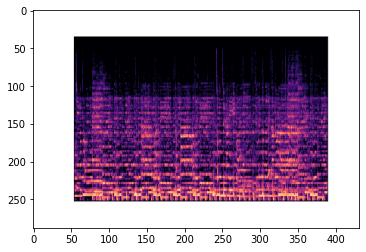

Il formato dell'immagine è: (288, 432, 4)


In [ ]:
img_path = "GTZAN Dataset/images_original"
img = mpimg.imread(img_path + '/rock/rock00093.png')
imgplot = plt.imshow(img)
plt.show()
print('Il formato dell\'immagine è:', img.shape)

In [ ]:
batch_size = 32
im_size = (img.shape[0], img.shape[1])

## Funzioni

Definiamo una funzione per calcolare i parametri di normalizzazione (media e varianza) di un dataset

In [ ]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(), std.numpy()

Ora definiamo un encoder e un decoder per mappare le classi in interi e viceversa

In [ ]:
def encoder(data):
  classes = data.classes
  encoder = {}
  for i in range(len(classes)):
    encoder[i] = classes[i]
  return encoder

def decoder(data):
  classes = data.classes    
  decoder = {}
  for i in range(len(classes)):
    decoder[classes[i]] = i
  return decoder

Definiamo quindi una funzione che stampa randomicamente dal dataset delle immagini

In [ ]:
def class_plot(data,n_figures = 12):
  n_row = int(n_figures/4)
  fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
  for ax in axes.flatten():
    a = random.randint(0,len(data))
    (image,label) = data[a]
    label = int(label)
    encoders = encoder(data)
    l = encoders[label]
    image = image.numpy().transpose(1,2,0)
    im = ax.imshow(image)
    ax.set_title(l)
    ax.axis('off')
  plt.show()

## Prepariamo i dati

### Trasformazioni

In [ ]:
train_transforms = transforms.Compose([
                                       transforms.Resize(im_size),
                                       transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
mean, std = normalization_parameter(train_loader)

  0%|          | 0/32 [00:00<?, ?it/s]

Qui è dove interviene l'Image Augumentation. Eseguiamo ranomicamente delle trasformazioni sulle immagini come crop, rotazioni e flip

In [ ]:
train_transforms = transforms.Compose([transforms.Resize(im_size),
                                        transforms.RandomResizedCrop(size = 315, scale = (0.95, 1.0)),
                                        transforms.RandomRotation(degrees = 10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size = 299),  # standard di Image Net
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
])
test_transforms = transforms.Compose([
                                        transforms.Resize(im_size),
                                        transforms.CenterCrop(size = 299),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
])

### Creazione dataset

In [ ]:
dataset = torchvision.datasets.ImageFolder(root = img_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = img_path, transform = test_transforms)

## Visualizziamo i dati nuovamente

Prima dell'image augumentation

In [ ]:
class_plot(train_data)

Dopo l'image augumentation

In [ ]:
class_plot(dataset)

## Prepariamo i dataset

Procediamo con un `random_split` per dividere il dataset completo in dei dataseti di addestramento, validazione e test

In [ ]:
torch.manual_seed(43)
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(800, 199)

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

## Definiamo il modello

### Funzione di Accuracy

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Modello

Definiamo il nostro modello di classificazione. Contiene cinque layers di Fully Connected con attivazioni ReLU su tutti i layers escluso l'ultimo che farà da vero e proprio discriminatore. Inseriamo nel modello dei metodi da richiamare ad ogni step di allenamento e validazione che si occuperanno di calcolare per ogni step le Cross Entropy Loss e l'accuracy tramite la funzione definita in precedenza. Queste verranno poi combinate alla fine di ogni epoca

In [ ]:
class Model(nn.Module):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 128)
    self.linear4 = nn.Linear(128, 32)
    self.linear5 = nn.Linear(32, output_size)

  def forward(self, xb):
    out = xb.view(xb.size(0), -1)
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    return out

  def training_step(self, batch):
    image,labels = batch
    out = self(image)
    loss = F.cross_entropy(out, labels)
    return loss
   
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combiniamo le Loss
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combiniamo le Accuracy
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

### Funzioni di training e evaluation

Definiamo delle funzioni per addestrare e validare il modello

In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    # Training 
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
def plot_losses(history):
  losses = [x['val_loss'] for x in history]
  plt.plot(losses, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')

def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

### Data Loader

Definiamo il nostro data loader. La scelta del device a cui assegnare le risorse avverrà direttamente da qui

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
        
  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
train_loader = DataLoader(train_loader, device)
val_loader = DataLoader(val_loader, device)
test_loader = DataLoader(test_loader, device)

NameError: ignored

### Training

In [ ]:
model = to_device(Model(3 * 299 * 299, 10), device)

In [ ]:
history = [evaluate(model, val_loader)]
print(history)

In [ ]:
epochs = {1e-2 : 50, 1e-3 : 50, 1e-5 : 50, 1e-6 : 50}

In [ ]:
for lr, epoch in epochs.items():
    history += fit(epoch,lr, model, train_loader, val_loader)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

### Testing

In [ ]:
torch.save(model.state_dict(), 'models/pt/GC_imgaug/GC_imgaug.pth')

In [ ]:
model = Model(3 * 299 * 299, 10)
model.load_state_dict(torch.load('models/pt/GC_imgaug/GC_imgaug.pth'))
model.eval()

Model(
  (linear1): Linear(in_features=268203, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
test = evaluate(model, test_loader)

NameError: ignored

In [ ]:
test_acc = test['val_acc']
test_loss = test['val_loss']
print("Accuracy:", test_acc)
print("Loss:", test_loss)